In [146]:
from svdunfold import SVDunfold
import svdunfold
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy.signal import fftconvolve
from matplotlib.colors import LogNorm
from scipy import stats
import random
from scipy.interpolate import interp1d

In [178]:
nevents=100000
x0 = 1842 # M2
gamma0 = 6
x1 =  2047 # M1
gamma1 = 13.2
mu = (x0+x1)/2.  # Media rumore
sigma = 7

gaussian_par=[mu,sigma]
cauchy_par_0=[x0,gamma0]
cauchy_par_1=[x1,gamma1]

x_min=1400
x_max=2500
x_nbins=220
b_min=1400
b_max=2500
b_nbins=220

def bins_and_centers(nbins, low, high):
    bins = np.linspace(low, high, nbins + 1)
    bin_centers = (bins + (bins[1] - bins[0]) / 2)[:-1]
    return bins, bin_centers

## xini  -> che simula l'energia come dovrebbe essere senza detector

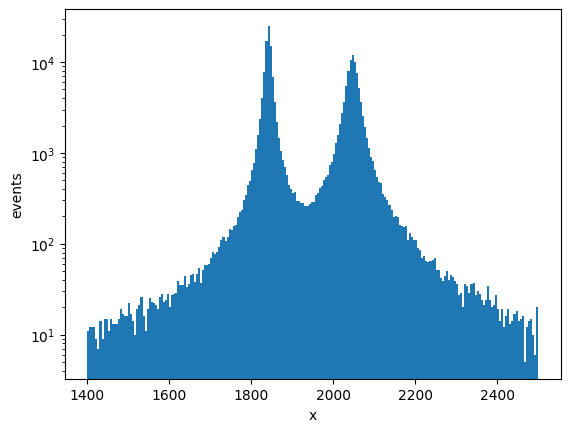

In [179]:
xini_peak_0 = stats.cauchy.rvs(cauchy_par_0[0], cauchy_par_0[1], nevents) 
xini_peak_1 = stats.cauchy.rvs(cauchy_par_1[0], cauchy_par_1[1], nevents) 

xini_peak = np.array([])
xini_peak = np.append(xini_peak, xini_peak_1)
xini_peak = np.append(xini_peak, xini_peak_0)

plt.hist(xini_peak, x_nbins, range=[x_min,x_max])

plt.ylabel("events")
plt.xlabel("x")
plt.yscale("log")

In [180]:
xini_rms = stats.norm.rvs(gaussian_par[0], gaussian_par[1], nevents) 

xini_peak_hist_0 = np.histogram(xini_peak_0, x_nbins, range=[x_min,x_max])
xini_peak_integral_0 = xini_peak_hist_0[0].sum() * (xini_peak_hist_0[1][1] - xini_peak_hist_0[1][0])

xini_peak_hist_1 = np.histogram(xini_peak_1, x_nbins, range=[x_min,x_max])
xini_peak_integral_1 = xini_peak_hist_1[0].sum() * (xini_peak_hist_1[1][1] - xini_peak_hist_1[1][0])

xini_rms_hist = np.histogram(xini_rms, x_nbins, range=[x_min,x_max])
xini_rms_integral = xini_rms_hist[0].sum() * (xini_rms_hist[1][1] - xini_rms_hist[1][0])

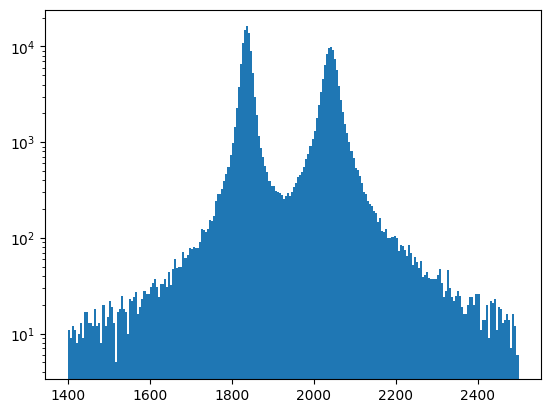

In [181]:
x = np.linspace(x_min, x_max, nevents)

pdf_peak_0 = stats.cauchy.pdf(x,cauchy_par_0[0], cauchy_par_0[1]) 
pdf_peak_1 = stats.cauchy.pdf(x,cauchy_par_1[0], cauchy_par_1[1]) 
pdf_rms = stats.norm.pdf(x,gaussian_par[0], gaussian_par[1]) 

pdf_peak = xini_peak_integral_1*pdf_peak_1+pdf_peak_0*xini_peak_integral_0
pdf_rms = pdf_rms*xini_rms_integral
convolved = fftconvolve(pdf_peak, pdf_rms, mode='same')

convolved /= np.sum(convolved) * (x[1] - x[0]) 

# Creazione della CDF dalla PDF
cdf = np.cumsum(convolved) * (x[1] - x[0])
cdf /= cdf[-1]  # Normalizzazione della CDF

# Interpolazione inversa della CDF per generare numeri casuali
inverse_cdf = interp1d(cdf, x, bounds_error=False, fill_value=(x_min, x_max))

random_uniform = np.random.uniform(0, 1, nevents*2)  # Numeri uniformi [0, 1]
b = inverse_cdf(random_uniform)  # Numeri distribuiti secondo 'convolved'


plt.hist(b, x_nbins, range=[x_min,x_max])
plt.yscale("log")


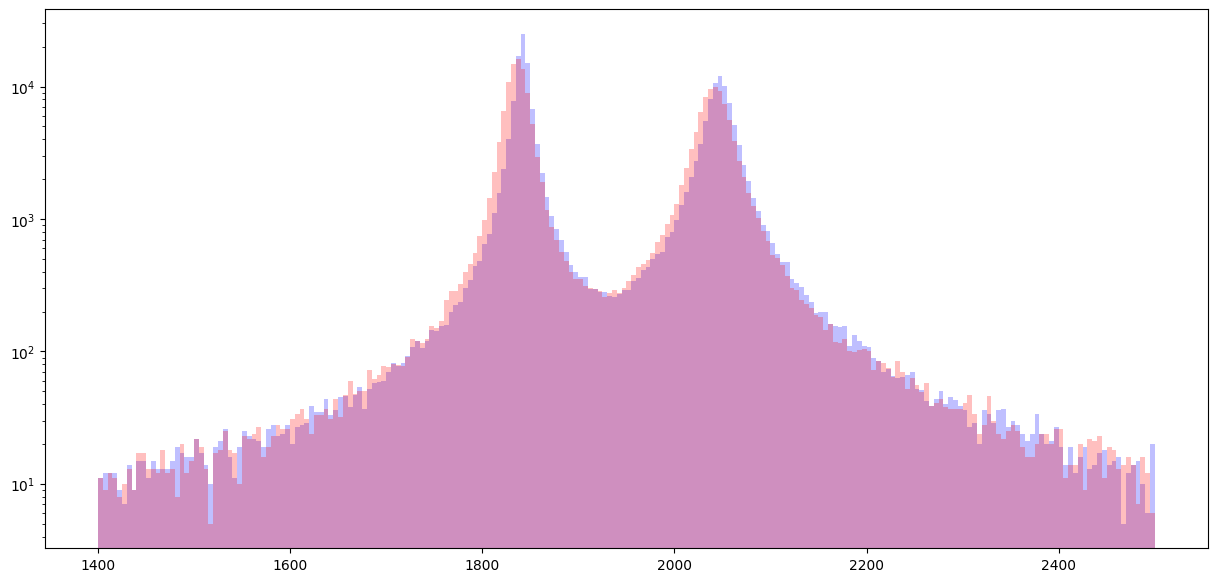

In [182]:
xini_matrix = np.histogram(xini_peak, x_nbins, range=[x_min,x_max])
b_matrix = np.histogram(b, b_nbins, range=[b_min,b_max])

plt.figure(figsize=(15, 7))

plt.hist(xini_peak, density=False, bins=x_nbins, range=[x_min,x_max], histtype="stepfilled", color="blue", 
         label="$x_{ini}$", alpha=0.25, weights=scale_factor*np.ones(len(x_ini_gen)))
plt.hist(b, density=False, bins=x_nbins, range=[x_min,x_max], histtype="stepfilled", color="red", label="$x_{test}$", alpha=0.25)
plt.yscale("log")

plt.show()

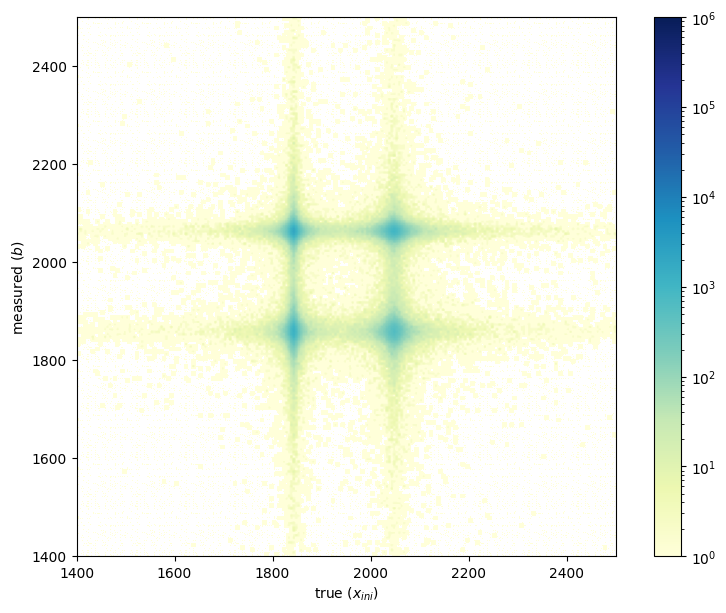

In [183]:
A_matrix=np.histogram2d(xini_peak,b, bins=[x_nbins,b_nbins], range=[[x_min,x_max],[b_min,b_max]])[0].T
plt.figure(figsize=(10, 7))

plt.imshow((A_matrix), norm=LogNorm(vmin=1, vmax=1e6), cmap="YlGnBu",\
           extent=[x_min,x_max,b_min,b_max])
plt.xlabel("true ($x_{ini}$)")
plt.ylabel("measured ($b$)")
plt.colorbar()

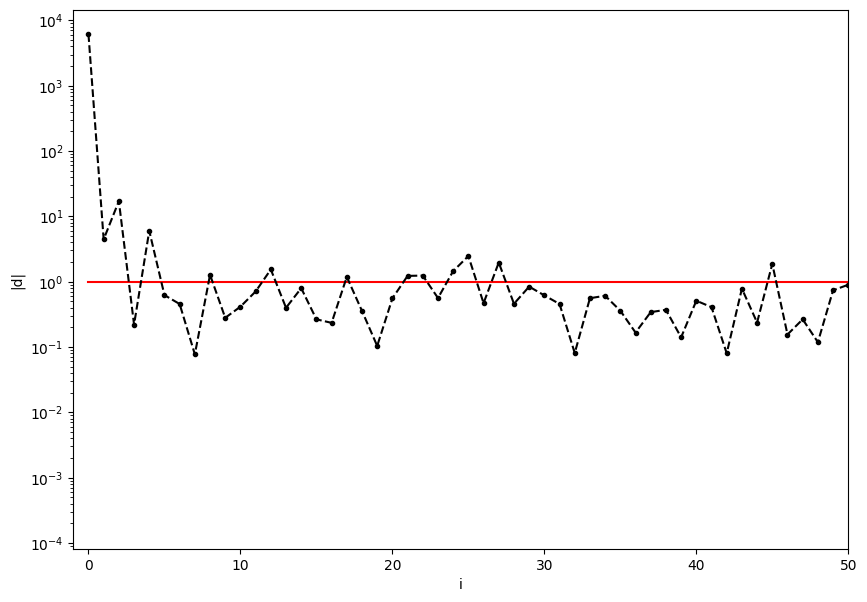

In [184]:
unfold = svdunfold.SVDunfold(xini_matrix, b_matrix, A_matrix, x_min,x_max,b_min,b_max, 0.001)
unfold.pre_unfolding()

d = unfold.get_abs_d()

plt.figure(figsize=(10, 7))

plt.plot(np.arange(len(d)), np.ones(len(d)), "r-" )
plt.plot(np.arange(len(d)), d, "k.--")
plt.xlim(-1,50)
plt.xlabel("i")
plt.ylabel("|d|")
plt.yscale("log")

<Figure size 1500x700 with 0 Axes>

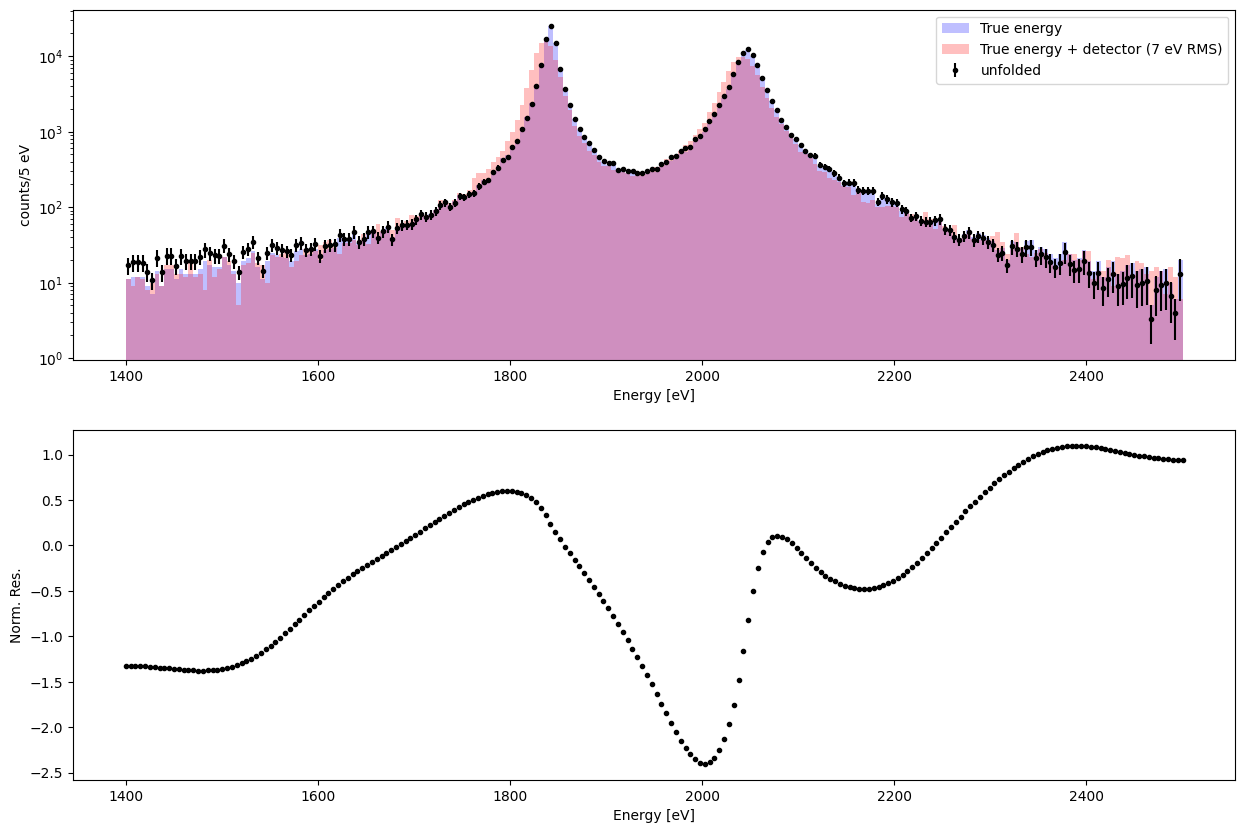

In [185]:
k=9
unfold.unfolding(k)  # Chiama il metodo unfolding
x = unfold.get_x_unfolded()
X = unfold.get_X_unfolded_covariance()

plt.figure(figsize=(15, 7))
aa = np.linspace(x_min, x_max, x_nbins)
    
plt.subplots(2 , 1, figsize=(15, 10))
plt.subplot(2,1,1)
plt.hist(xini_peak, density=False, bins=unfold._nx, range=[x_min, x_max], histtype="stepfilled", color="blue", alpha=0.25, label="True energy")
plt.hist(b, density=False, bins=unfold._nb,range=[b_min, b_max], histtype="stepfilled", color="red", alpha=0.25, label="True energy + detector ({} eV RMS)".format(sigma))
bins_x, bin_centers_x = bins_and_centers(unfold._nx, x_min, x_max)
plt.errorbar(bin_centers_x, x, fmt="k.", yerr=np.sqrt(np.diagonal(X)), label="unfolded")
plt.xlabel("Energy [eV]")
plt.ylabel("counts/5 eV")
plt.legend()
plt.yscale("log")
plt.subplot(2,1,2)
plt.plot(aa,(xini_matrix[0]-x)/np.sqrt(np.diag(X)), marker='.', linestyle="", color="black")
plt.xlabel("Energy [eV]")
plt.ylabel("Norm. Res.")
plt.savefig("{}eVRMS_binwidth{}.pdf".format(sigma, (x_max-x_min)/x_nbins))
plt.show()


Text(0, 0.5, 'measured ($b$)')

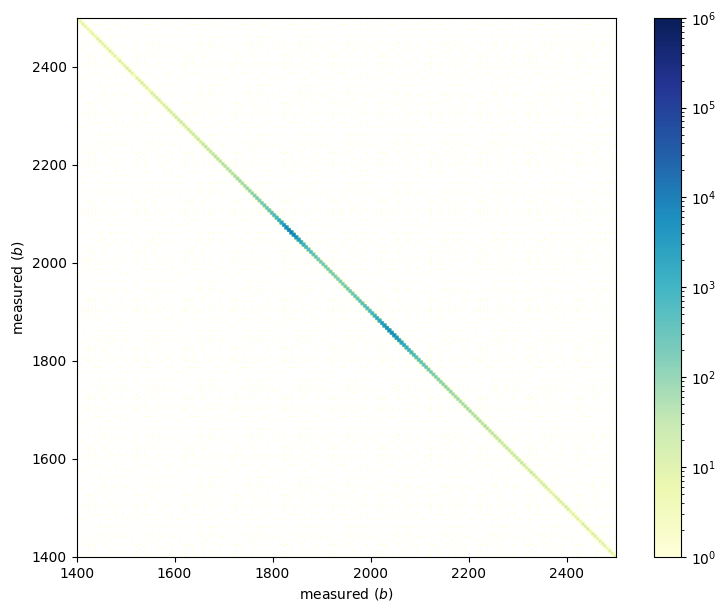

In [186]:
B = unfold.get_cov()

plt.figure(figsize=(10, 7))

plt.imshow(B, norm=LogNorm(vmin=1, vmax=1e6), cmap="YlGnBu",\
           extent=[x_min,x_max,b_min,b_max])
plt.colorbar()
plt.xlabel("measured ($b$)")
plt.ylabel("measured ($b$)")

Text(0, 0.5, 'unfolded x')

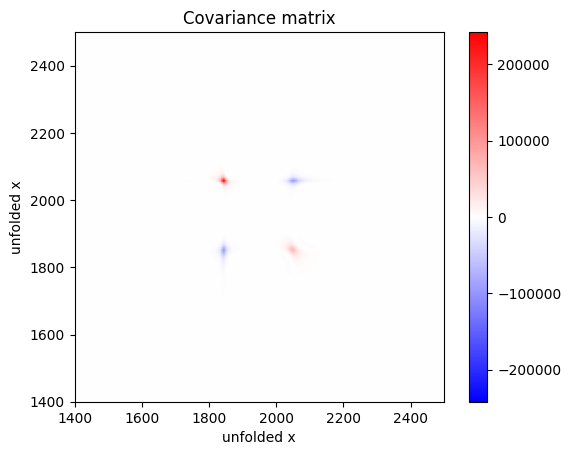

In [187]:
plt.imshow(X, cmap="bwr", vmin=-np.max(X),extent=[x_min,x_max,b_min,b_max])
plt.colorbar()
plt.title("Covariance matrix")
plt.xlabel("unfolded x")
plt.ylabel("unfolded x")